# 4 ODEs

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal
from sklearn import preprocessing 
import math
import time
import concurrent.futures
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from os import makedirs
from errno import EEXIST

## Riju ODEs

- Results processing for SMCABC_DESeq_riju_4ODEs_maxscore.py


In [2]:
# Set constants
#L = 0.8
#c = 10
G= 1

# settings
num_params = 17
hits_needed = 1000
cutoff1 = 5 # accepts like 40%
target_thresh = 0.2

prop = 0.60

prior_min = -3
prior_max = 3

gene_names=['IRX3', 'PAX6', 'OLIG2', 'NKX2-2']

# ODE functions
paramnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'psiI', 'psiP', 'psiO', 'psiN', 'scores']



In [11]:
###### Results processing ######

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[2])**2)*(1+((10**K_NI)*X[3])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[2])**2)*(1+((10**K_NP)*X[3])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[0])**2)*(1+((10**K_NO)*X[3])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[0])**2)*(1+((10**K_PN)*X[1])**2)*(1+((10**K_ON)*X[2])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dI_dt = (10**r_s)*phi_I - (10**gamma_s)*X[0]
    dP_dt = (10**r_s)*phi_P - (10**gamma_s)*X[1]
    dO_dt = (10**r_s)*phi_O- (10**gamma_s)*X[2]
    dN_dt = (10**r_s)*phi_N- (10**gamma_s)*X[3]

    return np.array([dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span = t_range, t_eval=tpts, args =tuple(parameter_list), dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 


### load data functions ###
def load_data(csvname, gene_names, mouse=True):
    df = pd.read_csv(csvname) # load csv
    df = pd.read_csv(csvname) # load csv
    df = df.loc[df['Gene'].isin(gene_names)] # select genes of interest only
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

    # initialise empty variables
    start=0
    end=0
    timepts=[]

    if mouse:
        df = df[df.columns.drop(list(df.filter(regex='h_')))]
        df = df[df.columns.drop(list(df.filter(regex='m_0_')))]
        end=33

    else:
        df = df[df.columns.drop(list(df.filter(regex='m_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_0_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_1_')))]
        end=39

    means=[]

    for gene_id in gene_names:
        genearr = np.array(df[df.Gene == gene_id].drop(labels='Gene', axis =1))
        genes_scaled = min_max_scaler.fit_transform(genearr.reshape(len(genearr[0]),1)) # normalise data from 0 to 1
        genes_scaled = genes_scaled.reshape(1,len(genes_scaled))[0]
        rep1 = genes_scaled[[i for i in range(0,end,3)]]
        rep2 = genes_scaled[[i for i in range(1,end,3)]]
        rep3 = genes_scaled[[i for i in range(2,end,3)]]

        repmean=(rep1+rep2+rep3)/3
        means.append(repmean)

    run_array = np.array(means).T
    return run_array

def plot_trajectories(run_output, thresh):
    run = run_output
    _, ax = plt.subplots()
    for i in range(len(run)):
        ax.plot(tpts, run[i][:, 0], "--", color="peachpuff")
        ax.plot(tpts, run[i][:, 1], "--", color="palegreen")
        ax.plot(tpts, run[i][:, 2], "--", color="lightcoral")
        ax.plot(tpts, run[i][:, 3], "--", color="cornflowerblue")

    ax.plot(timepts, observed[:, 0], "-", label="[I]", color = "orange")
    ax.plot(timepts, observed[:, 1], "-", label="[P]", color = "green")
    ax.plot(timepts, observed[:, 2], "-", label="[O]", color = "crimson")
    ax.plot(timepts, observed[:, 3], "-", label="[N]", color = "blue")

    ax.set_xlabel("time steps")
    ax.set_ylabel("concentration")
    ax.set_title("finding " + str(num_params) +" parameters")
    ax.legend(loc="upper right");
    plt.savefig("simulated_trajectories_"+spec+"/"+time.strftime("%Y_%m_%d_%H%M") + "_trajectories_at_thresh" + str(thresh) + ".png")


def get_posteriors(observed, param_df, thresh):


#     # # grid plot - separate out diff parameters
#     print("Making gridplot...")
#     g = sns.PairGrid(param_df, hue='scores', vars = ['param_' + str(n) for n in range(1,num_params+1)])
#     g.map_diag(sns.kdeplot, hue= None)
#     g.map_upper(sns.scatterplot, palette="icefire", s=10)
#     g.map_lower(sns.scatterplot, palette="icefire", s=10)
#     g.set(xlim=(prior_min, prior_max))
#     g.set(ylim=(prior_min, prior_max))
#     plt.savefig(spec+"_"+time.strftime("%Y_%m_%d_%H%M")+"_SMCgridplot_thresh" + str(thresh) + ".png")

    # # get best scores
    param_df.drop(labels='scores', inplace = True, axis =1)
    peaks =[]
    for col in param_df:
        ax = sns.kdeplot(param_df[col], label=str(col))
        points = ax.get_lines()[0].get_data()
        max_y = np.max(points[1])
        index = np.where(points[1] == max_y)
        max_x = points[0][index]
        peaks.append(max_x[0])
        ax.clear()

    unlogged = list(10**np.array(peaks))
    resultsdf = pd.DataFrame(list(zip(paramnames, peaks, unlogged)), columns = ['param', 'logged posterior', 'posterior'])
    print('\nposterior values:\n')
    print(resultsdf)

    simulateposterior = simulate_data(peaks)

    def get_cohen_score(go, obs):
        diff = abs(go-obs)
        scores = np.array([0,0,0,0])
        for point in diff:
            for gene in range(4):
                if point[gene] > 0.2:
                    scores[gene] +=1

        return scores/len(diff)

#     euclideandist_score = np.sqrt(np.sum((simulateposterior-observed)**2, axis=0))
#     cohen_score = get_cohen_score(simulateposterior, observed)

#     scoredf = pd.DataFrame(list(zip(gene_names, euclideandist_score, cohen_score)), columns = ['genes', 'euclidean distance', 'Cohen score'])
#     print('\n posterior scores:\n')
#     print(scoredf)

    ### plot simulation from posterior against observed data ###

    sns.color_palette('colorblind')
    _, ax = plt.subplots()
    ax.plot(tpts, simulateposterior[:, 0], "--", color="orange",label="[mIrx3]")
    ax.plot(tpts, simulateposterior[:, 1], "--", color="green",label="[mPax6]")
    ax.plot(tpts, simulateposterior[:, 2], "--", color="crimson",label="[mOlig2]")
    ax.plot(tpts, simulateposterior[:, 3], "--", color="blue",label="[mNkx2.2]")

    ax.plot(timepts, observed[:, 0], "-", label="[mIrx3]", color = "orange")
    ax.plot(timepts, observed[:, 1], "-", label="[mPax6]", color = "green")
    ax.plot(timepts, observed[:, 2], "-", label="[mOlig2]", color = "crimson")
    ax.plot(timepts, observed[:, 3], "-", label="[mNkx2.2]", color = "blue")

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Normalised levels")
    ax.set_title("")
    ax.legend(loc='center right', bbox_to_anchor=(2, 2), fontsize=15);
#     loc='center right', bbox_to_anchor=(2, 2), fontsize=32, ncol=len(ax.lines)
    plt.show()

#     plt.savefig(spec +"_"+ time.strftime("%Y_%m_%d_%H%M") + "_posterior_trajectory"+ "_thresh" + str(thresh) + ".png")




posterior values:

      param  logged posterior   posterior
0       r_s          0.508781    3.226869
1   gamma_s         -0.238862    0.576950
2      K_NI         -0.733415    0.184750
3      K_OI          2.214133  163.731833
4      K_NP          2.289208  194.629360
5      K_OP          1.520522   33.152945
6      K_IO         -0.846538    0.142384
7      K_NO          0.756533    5.708647
8      K_GO          1.518314   32.984799
9      K_IN         -0.716177    0.192231
10     K_PN          1.773036   59.297396
11     K_ON         -0.564079    0.272848
12     K_GN         -0.590624    0.256670
13     psiI         -1.644647    0.022665
14     psiP         -2.193096    0.006411
15     psiO         -2.349210    0.004475
16     psiN         -0.701445    0.198864


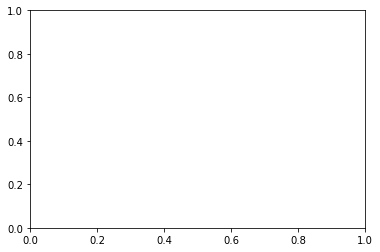

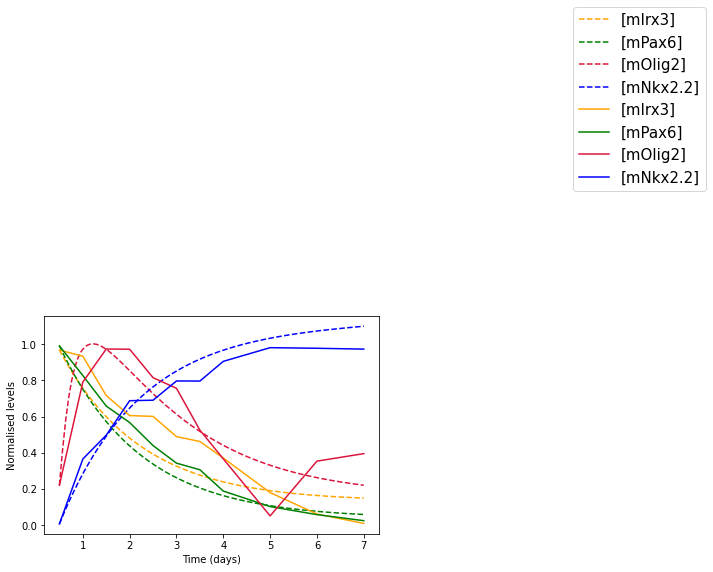

In [12]:
MOUSE=True

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'
    tpts = np.linspace(2,15,100)


mouse4_riju_df = pd.read_csv('MOUSE4_riju_2021_03_11_1426_final_params_thresh0.3.csv')
mouse4_riju_df.drop('Unnamed: 0', inplace=True, axis=1)
mouse4_riju_df.columns = paramnames
# print(mouse4_riju_df.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)    
get_posteriors(observed, mouse4_riju_df, 0.3)



        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0  0.210769 -0.649581  2.112469  2.865334  0.904464  1.990640 -0.552600   
1 -0.105777 -0.577091  0.946248  2.375735 -2.621839  1.150833 -2.920583   
2  0.047795 -0.586882 -0.054695  0.990210  2.487845  0.111712 -2.760451   
3 -0.029236 -0.650511  1.652703  1.586903 -2.947343  2.315925 -0.905675   
4 -0.479448 -0.505264  2.233479 -1.847623  0.902078 -0.349545 -0.947017   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      psiI  \
0  0.957447  1.509195  2.622576  1.055955 -1.052262 -2.154446 -2.606408   
1  0.540955  1.394768  0.953265 -2.156561 -1.631103 -0.449798 -2.104566   
2  0.805171  2.702107 -0.387005  0.631559 -0.653380 -0.461606 -2.060582   
3  0.643047  0.825728  0.074560 -2.130068 -0.577172 -0.441184 -1.764663   
4  0.571493  2.040723  0.068274  0.588963 -0.387511  2.047277 -2.248151   

       psiP      psiO      psiN    scores  
0 -2.885377 -1.395187 -0.967467  0.130776  
1 -2.23128

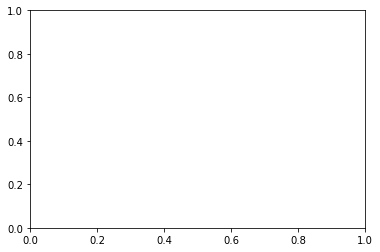

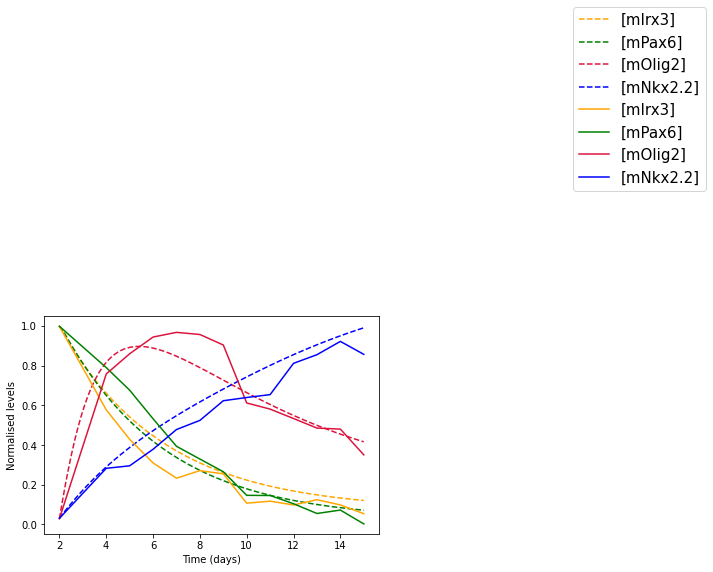

In [20]:
MOUSE=False

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    tpts = np.linspace(2,15,100)
    spec='human'

human4_riju_df = pd.read_csv('HUMAN4_riju_2021_03_11_1540_final_params_thresh0.2.csv')

# param_df.drop(labels='scores', inplace = True, axis =1)
human4_riju_df.drop('Unnamed: 0', inplace=True, axis=1)
human4_riju_df.columns = paramnames

print(human4_riju_df.head())
observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)    
get_posteriors(observed, human4_riju_df, 0.2)


In [21]:
# print(mouse4_riju_df.head())

# df_list = df.values.tolist()

mouselist = mouse4_riju_df.values.tolist()

mouseruns=[]
for particle in mouselist:
    go = simulate_data(particle)
    mouseruns.append(go)
    
# print(mouselist)

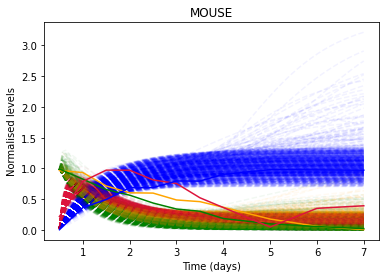

In [22]:
# set observed
MOUSE=True

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'
    tpts = np.linspace(2,15,100)

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE) 

# plt.clear()
_, ax = plt.subplots()
for i in range(len(mouseruns)):
    ax.plot(tpts, mouseruns[i][:, 0], "--", color="orange", alpha=0.05)
    ax.plot(tpts, mouseruns[i][:, 1], "--", color="green",alpha=0.05)
    ax.plot(tpts, mouseruns[i][:, 2], "--", color="crimson",alpha=0.05)
    ax.plot(tpts, mouseruns[i][:, 3], "--", color="blue",alpha=0.05)

ax.plot(timepts, observed[:, 0], "-", label="[mIrx3]", color = "orange")
ax.plot(timepts, observed[:, 1], "-", label="[mPax6]", color = "green")
ax.plot(timepts, observed[:, 2], "-", label="[mOlig2]", color = "crimson")
ax.plot(timepts, observed[:, 3], "-", label="[mNkx2.2]", color = "blue")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalised levels")
ax.set_title("MOUSE")
# ax.legend(loc="upper right", fontsize=15);

plt.show()

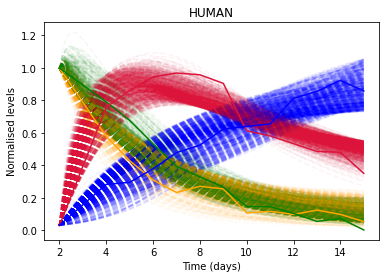

In [19]:
hlist = human4_riju_df.values.tolist()

hruns=[]
for particle in hlist:
    go = simulate_data(particle)
    hruns.append(go)
    
# set observed
MOUSE=False

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'
    tpts = np.linspace(2,15,100)

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE) 

# plt.clear()
_, ax = plt.subplots()
for i in range(len(mouseruns)):
    ax.plot(tpts, hruns[i][:, 0], "--", color="orange", alpha=0.05)
    ax.plot(tpts, hruns[i][:, 1], "--", color="green",alpha=0.05)
    ax.plot(tpts, hruns[i][:, 2], "--", color="crimson",alpha=0.05)
    ax.plot(tpts, hruns[i][:, 3], "--", color="blue",alpha=0.05)

ax.plot(timepts, observed[:, 0], "-", label="[mIrx3]", color = "orange")
ax.plot(timepts, observed[:, 1], "-", label="[mPax6]", color = "green")
ax.plot(timepts, observed[:, 2], "-", label="[mOlig2]", color = "crimson")
ax.plot(timepts, observed[:, 3], "-", label="[mNkx2.2]", color = "blue")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalised levels")
ax.set_title("HUMAN")
# ax.legend(loc="upper right", fontsize=15);

plt.show()

## Ruben

In [28]:
MOUSE=True
fL = 0.75
c = 10
G= 1

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'

mouse4_rub_df = pd.read_csv('MOUSE4_ruben_2021_03_11_1406_final_params_thresh0.3.csv')
# param_df.drop(labels='scores', inplace = True, axis =1)
mouse4_rub_df.drop('Unnamed: 0', inplace=True, axis=1)
mouse4_rub_df.columns = paramnames
print(mouse4_rub_df.head())



        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0  0.093904 -0.041636  0.449529 -1.433668  0.786548  0.475725 -1.966389   
1  0.290069 -0.117595  0.977255 -1.701496  2.611779  0.170703 -0.818956   
2  0.394149 -0.265026  0.931527  1.138972  0.608397 -0.593175 -1.086817   
3  0.066970 -0.258299  2.481010 -0.242042  0.680153 -1.830167 -2.663595   
4  0.277968 -0.131885  1.264568  0.226709  1.837468 -1.023493 -1.182100   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      K_LN  \
0  1.346214 -0.702708 -0.771334  0.596271 -1.475323  0.822456  0.134786   
1  2.015068  1.112770 -1.459739 -0.152422 -0.759308 -2.533218  0.177050   
2  1.632879  1.329010 -0.880760 -1.261778 -2.122333 -1.942424 -0.486873   
3  1.481460  1.250388 -0.053273 -1.851834 -1.065252  1.229574 -0.575861   
4  0.901319  1.183849 -0.268964 -1.771125 -1.701231 -1.907122 -0.000681   

       K_LP      K_LI      K_LO    scores  
0  0.578929  0.803683  1.575545  0.298278  
1 -0.12983

In [29]:
def get_posteriors(observed, param_df, thresh):

    # # grid plot - separate out diff parameters
#     print("Making gridplot...")
#     g = sns.PairGrid(param_df, hue='scores', vars = paramnames[:-1])
#     g.map_diag(sns.kdeplot, hue= None)
#     g.map_upper(sns.scatterplot, palette="icefire", s=10)
#     g.map_lower(sns.scatterplot, palette="icefire", s=10)
#     g.set(xlim=(prior_min, prior_max))
#     g.set(ylim=(prior_min, prior_max))
#     plt.savefig(spec+"_"+time.strftime("%Y_%m_%d_%H%M")+"_SMCgridplot_thresh" + str(thresh) + ".png")

    # # get best scores
    param_df.drop(labels='scores', inplace = True, axis =1)
    peaks =[]
    for col in param_df:
        ax = sns.kdeplot(param_df[col], label=str(col))
        points = ax.get_lines()[0].get_data()
        max_y = np.max(points[1])
        index = np.where(points[1] == max_y)
        max_x = points[0][index]
        peaks.append(max_x[0])
        ax.clear()

    print(peaks)
    unlogged = list(10**np.array(peaks))
    resultsdf = pd.DataFrame(list(zip(paramnames, peaks, unlogged)), columns = ['param', 'logged posterior', 'posterior'])
    print('\nposterior values:\n')
    print(resultsdf)

    simulateposterior = simulate_data(peaks)

    def get_cohen_score(go, obs):
        diff = abs(go-obs)
        scores = np.array([0,0,0,0])
        for point in diff:
            for gene in range(4):
                if point[gene] > 0.2:
                    scores[gene] +=1

        return scores/len(diff)

    euclideandist_score = np.sqrt(np.sum((simulateposterior-observed)**2, axis=0))
    cohen_score = get_cohen_score(simulateposterior, observed)

    scoredf = pd.DataFrame(list(zip(gene_names, euclideandist_score, cohen_score)), columns = ['genes', 'euclidean distance', 'Cohen score'])
    print('\n posterior scores:\n')
    print(scoredf)

    ### plot simulation from posterior against observed data ###

    sns.color_palette('colorblind')
    _, ax = plt.subplots()
    ax.plot(timepts, simulateposterior[:, 0], "--", color="orange")
    ax.plot(timepts, simulateposterior[:, 1], "--", color="green")
    ax.plot(timepts, simulateposterior[:, 2], "--", color="red")
    ax.plot(timepts, simulateposterior[:, 3], "--", color="cornflowerblue")

    ax.plot(timepts, observed[:, 0], "-", label="[I]", color = "orange")
    ax.plot(timepts, observed[:, 1], "-", label="[P]", color = "green")
    ax.plot(timepts, observed[:, 2], "-", label="[O]", color = "crimson")
    ax.plot(timepts, observed[:, 3], "-", label="[N]", color = "blue")

    ax.set_xlabel("time steps")
    ax.set_ylabel("concentration")
    ax.set_title(" varying K parameters")
    ax.legend(loc ='upper right');

    plt.savefig(spec +"_"+ time.strftime("%Y_%m_%d_%H%M") + "_posterior_trajectory"+ "_thresh" + str(thresh) + ".png")


[0.2640569193188078, -0.2598695223007794, 1.7267177963905533, 0.057575848636536975, 1.6737965682740406, -0.1748118266801919, -1.121531175366913, 1.6226438072099096, 1.3611237979320623, -0.7204883105640096, -0.941247077381298, -1.912654206668118, -1.8052858631507371, -0.2826997661014252, -1.4643619246634616, -0.0133917038803264, 1.0483352925770442]

posterior values:

      param  logged posterior  posterior
0       r_s          0.264057   1.836779
1   gamma_s         -0.259870   0.549706
2      K_NI          1.726718  53.298845
3      K_OI          0.057576   1.141763
4      K_NP          1.673797  47.184197
5      K_OP         -0.174812   0.668634
6      K_IO         -1.121531   0.075591
7      K_NO          1.622644  41.941485
8      K_GO          1.361124  22.968033
9      K_IN         -0.720488   0.190332
10     K_PN         -0.941247   0.114486
11     K_ON         -1.912654   0.012228
12     K_GN         -1.805286   0.015657
13     K_LN         -0.282700   0.521555
14     K_LP    

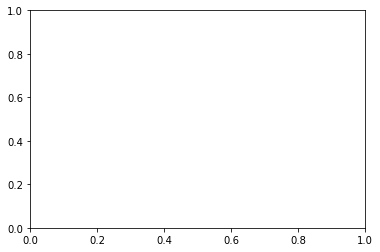

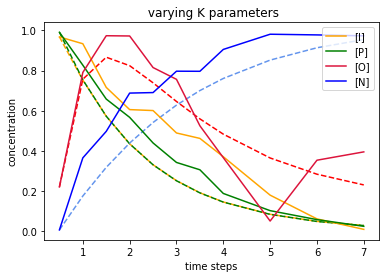

In [30]:

# I P O N

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, K_LN, K_LP, K_LI, K_LO):
    
    # Ruben's Phi's
    phi_I = (((10**K_LI)*L)/(((10**K_LI)*L)+((1+(10**K_OI)*X[2])**2)*(1+(10**K_NI)*X[3])**2))
    phi_P = (((10**K_LP)*L)/(((10**K_LP)*L)+((1+(10**K_OP)*X[2])**2)*(1+(10**K_NP)*X[3])**2))
    phi_O = (((10**K_LO)*L*(1+c*(10**K_GO)*G))/(((10**K_LO)*L*(1+c*(10**K_GO)*G))+(1+(10**K_GO))*((1+(10**K_NO)*X[3])**2)*((1+(10**K_IO)*X[0])**2)))
    phi_N = (((10**K_LN)*L*(1+c*(10**K_GN)*G))/(((10**K_LN)*L*(1+c*(10**K_GN)*G))+(1+(10**K_GN))*((1+(10**K_ON)*X[2])**2)*((1+(10**K_IN)*X[0])**2)*((1+(10**K_PN)*X[1])**2)))

    dI_dt = (10**r_s)*phi_I - (10**gamma_s)*X[0]
    dP_dt = (10**r_s)*phi_P - (10**gamma_s)*X[1]
    dO_dt = (10**r_s)*phi_O - (10**gamma_s)*X[2]
    dN_dt = (10**r_s)*phi_N - (10**gamma_s)*X[3]

    return np.array([dI_dt, dP_dt, dO_dt, dN_dt])  
    
    # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span = t_range, args =tuple(parameter_list), t_eval = timepts, dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, mouse4_rub_df, 0.3)

        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0 -0.309323 -0.526914  0.620718  0.106801  0.402997 -2.220746 -0.131996   
1 -0.326278 -0.432943 -0.677568  2.175248 -0.361044 -1.463967 -1.283256   
2 -0.359045 -0.483395 -0.558320  1.970832  1.879327 -1.169297 -0.767467   
3 -0.304993 -0.408859 -0.292845  2.898484  1.818056 -0.893830 -1.153366   
4 -0.378961 -0.430226  0.839036  1.370346  1.364072 -2.486744 -0.221260   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      K_LN  \
0  0.914368  1.501000 -0.085084  0.090967 -1.048350  0.562572 -0.351737   
1  1.338643 -1.156692  0.795114 -1.380969 -2.175152 -2.670594  0.800782   
2  1.419904  0.902828  0.703949 -0.986173 -1.412454 -1.281464  0.621387   
3  1.784756 -0.601051  0.510415 -0.595772 -2.741373 -1.730518  0.585162   
4  1.753911  0.943400  1.072062 -0.632416 -1.205476 -1.191735  1.483615   

       K_LP      K_LI      K_LO    scores  
0 -0.474438 -1.316299  0.558518  0.129875  
1 -0.43582

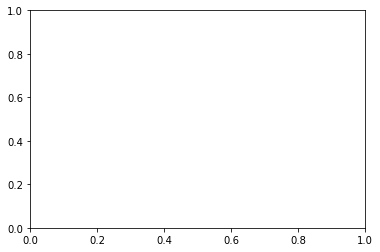

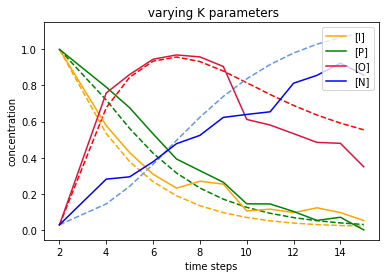

In [31]:
MOUSE=False
paramnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'K_LN', 'K_LP', 'K_LI','K_LO', 'scores']
L = 0.75
c = 10
G= 1

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'

human4_rub_df = pd.read_csv('HUMAN4_ruben_2021_03_11_1459_final_params_thresh0.2.csv')
# param_df.drop(labels='scores', inplace = True, axis =1)
human4_rub_df.drop('Unnamed: 0', inplace=True, axis=1)
human4_rub_df.columns = paramnames
print(human4_rub_df.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, human4_rub_df, 0.3)

# 8ODEs

In [32]:
def load_data(csvname, gene_names, mouse=True):
    df = pd.read_csv(csvname) # load csv
    df = df.loc[df['Gene'].isin(gene_names)] # select genes of interest only
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

    # initialise empty variables
    start=0
    end=0
    timepts=[]

    if mouse:
        df = df[df.columns.drop(list(df.filter(regex='h_')))]
        df = df[df.columns.drop(list(df.filter(regex='m_0_')))]
        end=33

    else:
        df = df[df.columns.drop(list(df.filter(regex='m_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_0_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_1_')))]
        end=39
            
    means=[]

    for gene_id in gene_names:
        genearr = np.array(df[df.Gene == gene_id].drop(labels='Gene', axis =1))
        genes_scaled = min_max_scaler.fit_transform(genearr.reshape(len(genearr[0]),1)) # normalise data from 0 to 1
        genes_scaled = genes_scaled.reshape(1,len(genes_scaled))[0]
        rep1 = genes_scaled[[i for i in range(0,end,3)]]
        rep2 = genes_scaled[[i for i in range(1,end,3)]]
        rep3 = genes_scaled[[i for i in range(2,end,3)]]

        repmean=(rep1+rep2+rep3)/3
        means.append(repmean)
        
    for n in range(4):
        means.append(means[n])
        
    run_array = np.array(means).T

    return run_array


## Riju

In [33]:
# ODE functions
paramnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'psiI', 'psiP', 'psiO', 'psiN', 'scores']
prior_min = -3
prior_max = 3
G= 1
alpha_s=100


def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[6])**2)*(1+((10**K_NI)*X[7])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[6])**2)*(1+((10**K_NP)*X[7])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[4])**2)*(1+((10**K_NO)*X[7])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[4])**2)*(1+((10**K_PN)*X[5])**2)*(1+((10**K_ON)*X[6])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]

    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]

    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span = t_range, args =tuple(parameter_list), t_eval = tpts, dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 


In [34]:
MOUSE=True

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383,0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577,0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    tpts = np.linspace(2,15,100)
    spec='human'

mouse8_riju_df = pd.read_csv('MOUSE8_riju_2021_03_13_0431_final_params_thresh0.4974474934820172.csv')
mouse8_riju_df.drop('Unnamed: 0', inplace=True, axis=1)
mouse8_riju_df.columns = paramnames
print(mouse8_riju_df.head())

        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0  0.203324  0.271100  0.348747 -0.539657  0.521591 -1.444289 -2.401546   
1  0.182468  0.193921  0.356056 -1.633087  0.467432 -1.092089 -0.914994   
2  0.160687  0.152943  0.299239 -1.003621  0.724807 -1.825660 -1.750969   
3  0.031983  0.032403  0.386921 -1.392417  0.686822 -1.224696 -2.228020   
4  0.183980  0.208262  0.445792 -1.142163  0.457710 -0.749328 -1.574637   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      psiI  \
0  0.122726  0.874500  0.169417  0.367855 -2.007728  2.716546 -1.841055   
1  0.145778  2.519094 -0.244434  0.178466 -2.932547  1.025016 -2.434072   
2  0.202424  2.714147 -2.896856  0.286968 -1.055982  0.970655 -2.739582   
3  0.176061  2.755801 -2.053073  0.288888 -1.311778  1.553282 -1.669417   
4  0.190115  1.029742 -2.132398  0.233656 -0.737201  2.533156 -1.853641   

       psiP      psiO      psiN    scores  
0 -2.186745 -1.851740 -0.515155  0.408659  
1 -1.68470

peaks [0.11928677269000768, 0.13643945475097527, 0.3351360202714764, -1.1140869706983687, 0.554653979807722, -0.8213741222706683, -1.1596089849017646, 0.15415506068498216, 1.2884445158236952, -0.38135087605095475, 0.26308701866288686, -1.3491407338190875, 1.148885082927443, -2.053448423486971, -1.6664867067557476, -2.4858924568735, -0.8604512791014938]

posterior values:

      param  logged posterior  posterior
0       r_s          0.119287   1.316094
1   gamma_s          0.136439   1.369114
2      K_NI          0.335136   2.163396
3      K_OI         -1.114087   0.076898
4      K_NP          0.554654   3.586361
5      K_OP         -0.821374   0.150878
6      K_IO         -1.159609   0.069245
7      K_NO          0.154155   1.426117
8      K_GO          1.288445  19.428735
9      K_IN         -0.381351   0.415575
10     K_PN          0.263087   1.832682
11     K_ON         -1.349141   0.044757
12     K_GN          1.148885  14.089159
13     psiI         -2.053448   0.008842
14     psi

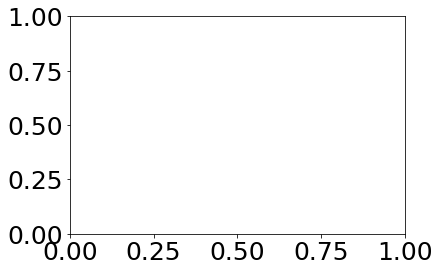

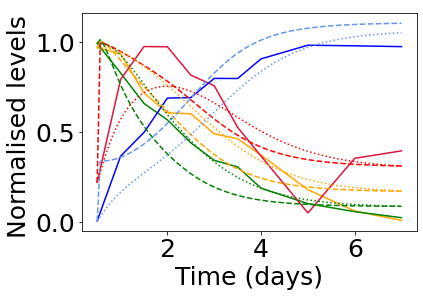

In [35]:

plt.rcParams.update({'font.size': 25})
def get_posteriors(observed, param_df, thresh):

    # # get best scores
    param_df.drop(labels='scores', inplace = True, axis =1)
    peaks =[]
    for col in param_df:
        ax = sns.kdeplot(param_df[col], label=str(col))
        points = ax.get_lines()[0].get_data()
        max_y = np.max(points[1])
        index = np.where(points[1] == max_y)
        max_x = points[0][index]
        peaks.append(max_x[0])
        ax.clear()
        
    print('peaks', peaks)

    unlogged = list(10**np.array(peaks))
    resultsdf = pd.DataFrame(list(zip(paramnames, peaks, unlogged)), columns = ['param', 'logged posterior', 'posterior'])
    print('\nposterior values:\n')
    print(resultsdf)

    simulateposterior = simulate_data(peaks)

    def get_cohen_score(go, obs):
        diff = abs(go-obs)
        scores = np.array([0,0,0,0])
        for point in diff:
            for gene in range(4):
                if point[gene] > 0.2:
                    scores[gene] +=1
                    
        return scores/4

#     euclideandist_score = np.sqrt(np.sum((simulateposterior-observed)**2, axis=0))
#     print(euclideandist_score)
#     cohen_score = get_cohen_score(simulateposterior, observed)

#     scoredf = pd.DataFrame(list(zip(gene_names, euclideandist_score, cohen_score)), columns = ['genes', 'euclidean distance', 'Cohen score'])
#     print('\n posterior scores:\n')
#     print(scoredf)

    ### plot simulation from posterior against observed data ###

    sns.color_palette('colorblind')
    _, ax = plt.subplots()
    ax.plot(timepts, observed[:, 0], "-", label="[mI]", color = "orange")
    ax.plot(timepts, observed[:, 1], "-", label="[mP]", color = "green")
    ax.plot(timepts, observed[:, 2], "-", label="[mO]", color = "crimson")
    ax.plot(timepts, observed[:, 3], "-", label="[mN]", color = "blue")
    
    ax.plot(tpts, simulateposterior[:, 0], "--", label="simulated [mI]",color="orange")
    ax.plot(tpts, simulateposterior[:, 1], "--", label="simulated [mP]",color="green")
    ax.plot(tpts, simulateposterior[:, 2], "--", label="simulated [mO]",color="red")
    ax.plot(tpts, simulateposterior[:, 3], "--", label="simulated [mN]",color="cornflowerblue")
    ax.plot(tpts, simulateposterior[:, 4], ":", label="simulated [I]",color="orange")
    ax.plot(tpts, simulateposterior[:, 5], ":", label="simulated [P]",color="green")
    ax.plot(tpts, simulateposterior[:, 6], ":", label="simulated [O]",color="red")
    ax.plot(tpts, simulateposterior[:, 7], ":", label="simulated [N]",color="cornflowerblue")


    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Normalised levels ")
#     ax.set_title("Riju 8ODEs" + str(spec))
#     ax.set_title("Scoring method 2: protein losely scored against mRNA data", fontsize =15)
#     ax.legend(bbox_to_anchor=(2.0, 2.0),loc ='upper right');

    plt.savefig(spec +"_"+ time.strftime("%Y_%m_%d_%H%M") + "_posterior_trajectory"+ "_thresh" + str(thresh) + ".png")
    plt.show()
    
    
observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, mouse8_riju_df, 0.5) 

        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0 -0.321716 -0.277636  0.882309 -1.115855  0.734245 -1.153190 -0.358427   
1 -0.231920 -0.242430  0.684312  0.366348  0.791673 -2.076253 -0.159845   
2 -0.227068 -0.211198  0.702902  0.039433  0.898162 -1.724598 -0.378805   
3 -0.161144 -0.128732  0.729304 -0.028419  0.760533 -1.568476 -0.377222   
4 -0.254792 -0.241077  0.972465 -0.092321  0.621647 -0.322874 -0.248562   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      psiI  \
0  0.207549  2.498823  0.506818 -2.140581 -1.045488  1.784019 -0.978755   
1  0.095719  0.929698  0.612356 -1.173444 -1.651793  1.488695 -1.082046   
2  0.111066  0.982400  0.511343 -2.112539 -2.173042  2.502931 -1.173929   
3  0.155461  1.540291  0.504216 -1.774448 -1.676979  1.810926 -1.140782   
4  0.093798  2.169032  0.643822 -0.818022 -1.107880  1.133617 -1.065953   

       psiP      psiO      psiN    scores  
0 -1.265549 -1.397787 -1.047224  0.218037  
1 -1.44655

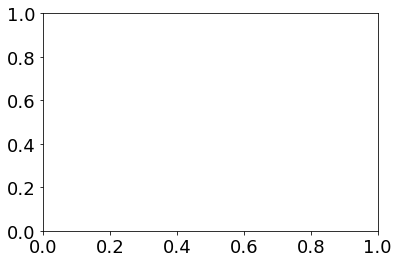

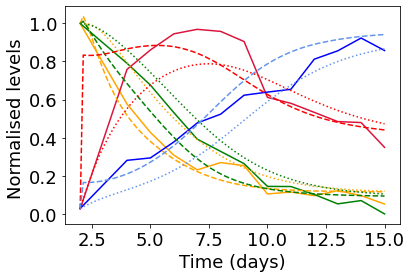

In [36]:

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[6])**2)*(1+((10**K_NI)*X[7])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[6])**2)*(1+((10**K_NP)*X[7])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[4])**2)*(1+((10**K_NO)*X[7])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[4])**2)*(1+((10**K_PN)*X[5])**2)*(1+((10**K_ON)*X[6])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]

    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]

    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])
plt.rcParams.update({'font.size': 18})
MOUSE=False

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383,0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577,0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    tpts = np.linspace(2,15,100)
    spec='human'

human8_riju_df = pd.read_csv('HUMAN8_riju_2021_03_13_1710_final_params_thresh0.3.csv')
human8_riju_df.drop('Unnamed: 0', inplace=True, axis=1)
human8_riju_df.columns = paramnames
print(human8_riju_df.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, human8_riju_df, 0.3) 


## Example from without protein scoring


        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0 -1.127906 -0.498879  1.076151  0.898106  1.867575 -2.811515 -1.502927   
1 -0.855463 -0.357301  0.834777  0.145966  1.849475 -0.380743 -0.200626   
2 -1.161153 -0.577073  2.048965  0.284119  1.423895 -0.147331 -2.514947   
3 -0.975311 -0.590265  0.844340 -0.984949  2.113921 -2.103877 -1.495748   
4 -0.924358 -0.519808  0.745916  0.526069  1.517195 -2.332542 -1.106196   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      psiI  \
0  1.450173 -2.381816  0.142115  1.289701 -0.118551 -1.606631  1.924780   
1  1.984185  2.775251  1.083977 -1.287001  1.202658  2.166147  1.284497   
2  1.807135  1.156471  1.212906  0.198567  0.669460  1.658746  1.414476   
3  1.532291  1.895161  0.934393  0.095386 -1.983001  0.296510  0.816513   
4  1.845191 -0.662849  1.241690  0.167511 -0.353949 -0.045585  1.352987   

       psiP      psiO      psiN    scores  
0  1.284170  0.961466  1.628135  0.260120  
1  1.51910

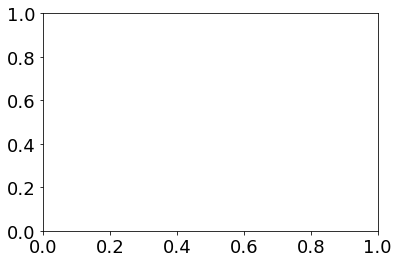

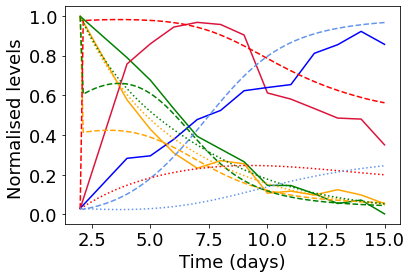

In [37]:
# _2021_03_11_2356_final_params_thresh0.35
# WITHOUT PROTEIN SCORING

L = 0.8
c = 10
G= 1
alpha_s=100

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, K_LN, K_LP, K_LI, K_LO):
    
    # Ruben's Phi's
    phi_I = (((10**K_LI)*L)/(((10**K_LI)*L)+((1+(10**K_OI)*X[6])**2)*(1+(10**K_NI)*X[7])**2))
    phi_P = (((10**K_LP)*L)/(((10**K_LP)*L)+((1+(10**K_OP)*X[6])**2)*(1+(10**K_NP)*X[7])**2))
    phi_O = (((10**K_LO)*L*(1+c*(10**K_GO)*G))/(((10**K_LO)*L*(1+c*(10**K_GO)*G))+(1+(10**K_GO))*((1+(10**K_NO)*X[7])**2)*((1+(10**K_IO)*X[4])**2)))
    phi_N = (((10**K_LN)*L*(1+c*(10**K_GN)*G))/(((10**K_LN)*L*(1+c*(10**K_GN)*G))+(1+(10**K_GN))*((1+(10**K_ON)*X[6])**2)*((1+(10**K_IN)*X[4])**2)*((1+(10**K_PN)*X[5])**2)))
    
    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]
   
    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]
    
    
    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])


MOUSE=False

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383,0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    tpts = np.linspace(0.5,7,100)
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577,0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    tpts = np.linspace(2,15,100)
    spec='human'

newdf = pd.read_csv('_2021_03_11_2356_final_params_thresh0.35.csv')
newdf.drop('Unnamed: 0', inplace=True, axis=1)
newdf.columns = paramnames
print(newdf.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, newdf, 0.35) 

## Ruben

In [38]:
# Set constants
L = 0.8
c = 10
G= 1
alpha_s=100

# settings
num_params = 17
hits_needed = 1000

cutoff1 = 5.7

prior_min = -3
prior_max = 3

gene_names=['IRX3', 'PAX6', 'OLIG2', 'NKX2-2']
paramnames = ['r_s', 'beta_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'K_LN', 'K_LP', 'K_LI','K_LO','scores']


if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383, 0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577, 0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'

# ODE functions
paramnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'K_LN', 'K_LP', 'K_LI','K_LO', 'scores']


def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, K_LN, K_LP, K_LI, K_LO):
    
    # Ruben's Phi's
    phi_I = (((10**K_LI)*L)/(((10**K_LI)*L)+((1+(10**K_OI)*X[6])**2)*(1+(10**K_NI)*X[7])**2))
    phi_P = (((10**K_LP)*L)/(((10**K_LP)*L)+((1+(10**K_OP)*X[6])**2)*(1+(10**K_NP)*X[7])**2))
    phi_O = (((10**K_LO)*L*(1+c*(10**K_GO)*G))/(((10**K_LO)*L*(1+c*(10**K_GO)*G))+(1+(10**K_GO))*((1+(10**K_NO)*X[7])**2)*((1+(10**K_IO)*X[4])**2)))
    phi_N = (((10**K_LN)*L*(1+c*(10**K_GN)*G))/(((10**K_LN)*L*(1+c*(10**K_GN)*G))+(1+(10**K_GN))*((1+(10**K_ON)*X[6])**2)*((1+(10**K_IN)*X[4])**2)*((1+(10**K_PN)*X[5])**2)))
    
    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]
   
    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]
    
    
    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span = t_range, args =tuple(parameter_list), t_eval = timepts, dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 

def get_posteriors(observed, param_df, thresh):

#     # grid plot - separate out diff parameters
#     print("Making gridplot...")
#     g = sns.PairGrid(param_df, hue='scores', vars = paramnames[:-1])
#     g.map_diag(sns.kdeplot, hue= None)
#     g.map_upper(sns.scatterplot, palette="icefire", s=10)
#     g.map_lower(sns.scatterplot, palette="icefire", s=10)
#     g.set(xlim=(prior_min, prior_max))
#     g.set(ylim=(prior_min, prior_max))
#     plt.savefig(spec+"_"+time.strftime("%Y_%m_%d_%H%M")+"_SMCgridplot_thresh" + str(thresh) + ".png")

    # # get best scores
    param_df.drop(labels='scores', inplace = True, axis =1)
    peaks =[]
    for col in param_df:
        ax = sns.kdeplot(param_df[col], label=str(col))
        points = ax.get_lines()[0].get_data()
        max_y = np.max(points[1])
        index = np.where(points[1] == max_y)
        max_x = points[0][index]
        peaks.append(max_x[0])
        ax.clear()

    unlogged = list(10**np.array(peaks))
    resultsdf = pd.DataFrame(list(zip(paramnames, peaks, unlogged)), columns = ['param', 'logged posterior', 'posterior'])
    print('\nposterior values:\n')
    print(resultsdf)

    simulateposterior = simulate_data(peaks)

    def get_cohen_score(simulated, experimental):
        diff = abs(simulated-experimental)
        scores = np.array([0,0,0,0])
        for point in diff:
            for gene in range(4):
                if point[gene] > 0.2:
                    scores[gene] +=1
                    
        return scores/len(diff)

    euclideandist_score = np.sqrt(np.sum((simulateposterior-observed)**2, axis=0))
    print(euclideandist_score)
    cohen_score = get_cohen_score(simulateposterior, observed)

    scoredf = pd.DataFrame(list(zip(gene_names, euclideandist_score, cohen_score)), columns = ['genes', 'euclidean distance', 'Cohen score'])
    print('\n posterior scores:\n')
    print(scoredf)

    ### plot simulation from posterior against observed data ###

    sns.color_palette('colorblind')
    _, ax = plt.subplots()
    ax.plot(timepts, simulateposterior[:, 0], "--", label="simulated [mI]",color="orange")
    ax.plot(timepts, simulateposterior[:, 1], "--", label="simulated [mP]",color="green")
    ax.plot(timepts, simulateposterior[:, 2], "--", label="simulated [mO]",color="red")
    ax.plot(timepts, simulateposterior[:, 3], "--", label="simulated [mN]",color="cornflowerblue")
    ax.plot(timepts, simulateposterior[:, 4], ":", label="simulated [I]",color="orange")
    ax.plot(timepts, simulateposterior[:, 5], ":", label="simulated [P]",color="green")
    ax.plot(timepts, simulateposterior[:, 6], ":", label="simulated [O]",color="red")
    ax.plot(timepts, simulateposterior[:, 7], ":", label="simulated [N]",color="cornflowerblue")

    ax.plot(timepts, observed[:, 0], "-", label="observed [mI]", color = "orange")
    ax.plot(timepts, observed[:, 1], "-", label="observed [mP]", color = "green")
    ax.plot(timepts, observed[:, 2], "-", label="observed [mO]", color = "crimson")
    ax.plot(timepts, observed[:, 3], "-", label="observed [mN]", color = "blue")

    ax.set_xlabel("time (days)")
    ax.set_ylabel("normalised concentration ")
    ax.set_title("Ruben 8ODEs" + str(spec))
    ax.legend(bbox_to_anchor=(1.4, 1.0),loc ='upper right');

    plt.savefig(spec +"_"+ time.strftime("%Y_%m_%d_%H%M") + "_posterior_trajectory"+ "_thresh" + str(thresh) + ".png")
    plt.show()
    
     

        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0 -0.319599 -0.311015  0.297734  0.351595  1.113150 -0.710392 -1.061798   
1 -0.255681 -0.267215  0.495559 -0.469900  0.790493 -2.422047 -1.838252   
2 -0.393406 -0.369992  0.687625  0.231579  1.095415 -1.498612 -1.686155   
3 -0.301976 -0.313250  0.700564  0.117793  0.693323 -1.327828 -2.780974   
4 -0.337252 -0.323944  0.714275 -0.207368  1.109073 -1.624535 -1.965995   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      K_LN  \
0  1.239569  1.396711 -0.119518  0.881687 -0.248377  2.873835  0.818486   
1  1.324263 -0.052704  0.617119  0.526151 -0.901803  1.509920  0.578933   
2  1.046712 -0.302094  0.446061  0.888721 -1.024654  2.710393  1.202520   
3  1.456267 -0.106637  0.868892  0.027015 -1.219951  1.341654  0.640556   
4  1.184923  0.818196  0.278802  0.868239 -0.534491  2.679326  0.889977   

       K_LP      K_LI      K_LO    scores  
0  1.173393  0.913891  1.395371  0.284208  
1  0.58826

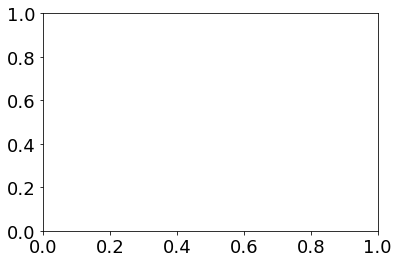

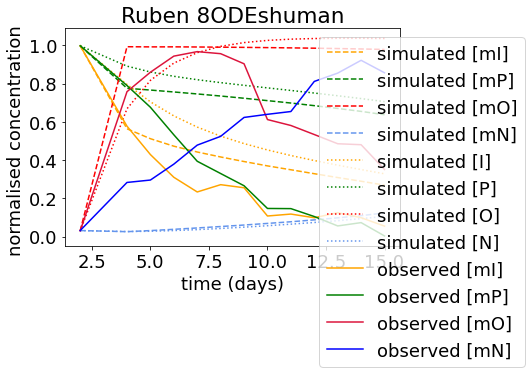

In [39]:
MOUSE=False

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383, 0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577, 0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'

human8_rub_df = pd.read_csv('HUMAN8_ruben_2021_03_13_1207_final_params_thresh0.35.csv')
human8_rub_df.drop('Unnamed: 0', inplace=True, axis=1)
human8_rub_df.columns = paramnames
print(human8_rub_df.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, human8_rub_df, 0.35) 


        r_s   gamma_s      K_NI      K_OI      K_NP      K_OP      K_IO  \
0  0.136373  0.105035  0.679982 -2.999780  1.106809 -0.014435 -1.549357   
1  0.130495  0.111026  0.730571 -1.185907  0.878452  0.381270 -1.257181   
2  0.165716  0.159772  0.630220 -2.834419  0.786553 -0.352722 -1.758057   
3  0.032012 -0.015956  0.492402 -0.971465  0.534494 -1.120606 -1.497753   
4  0.057108  0.042708  0.734423 -2.093862  1.237752 -0.344011 -1.070912   

       K_NO      K_GO      K_IN      K_PN      K_ON      K_GN      K_LN  \
0  1.351608  2.332334 -0.147329  1.593352 -1.975416 -0.029131  2.459670   
1  1.833759  1.964222  0.622451  1.167189 -0.719862 -0.006933  2.684960   
2  1.549673  1.877852  0.292956  1.538126 -1.213522  0.001231  2.788280   
3  1.452492  1.936740  0.589290  1.248363 -0.648480  1.681947  2.552287   
4  1.910403  1.918182  0.556153  0.957238 -1.762200  0.714409  1.955189   

       K_LP      K_LI      K_LO    scores  
0  1.745292  1.000997  1.487445  0.392010  
1  1.85320

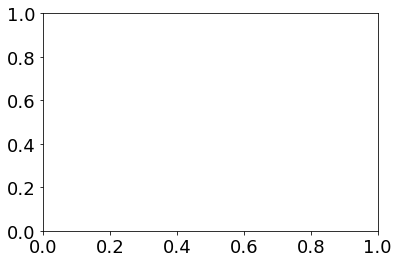

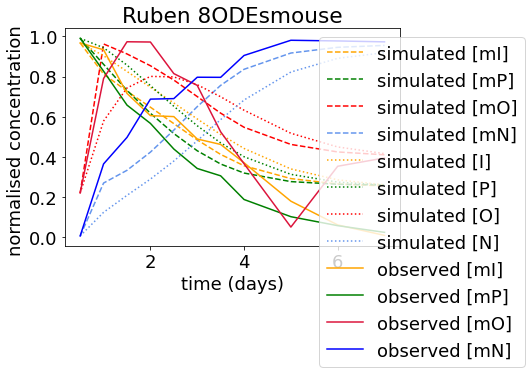

In [40]:
MOUSE=True

if MOUSE:
    # MOUSE INITIAL CONDITIONS - if mouse == True
    X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383, 0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]
    t_range = [0.5, 7]
    timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]
    spec='mouse'

else:
    # HUMAN INITIAL CONDITIONS - if mouse == False
    X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577, 0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
    t_range = [2,15]
    timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
    spec='human'

mouse8_rub_df = pd.read_csv('MOUSE8_ruben_2021_03_13_1343_final_params_thresh0.45067636708696424.csv')
mouse8_rub_df.drop('Unnamed: 0', inplace=True, axis=1)
mouse8_rub_df.columns = paramnames
print(mouse8_rub_df.head())

observed = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = MOUSE)
get_posteriors(observed, mouse8_rub_df, 0.45) 


# Comparing all

In [45]:
### r_s box plot

alldfs = [mouse4_riju_df, human4_riju_df, mouse4_rub_df, human4_rub_df, mouse8_riju_df, human8_riju_df, mouse8_rub_df, human8_rub_df]
names =['mouse new 4', 'human new 4', 'mouse old 4', 'human old 4', 'mouse new 8', 'human new 8', 'mouse old 8','human old 8']

rdf = mouse4_riju_df[['r_s']]
rdf.columns=[names[0]]

for i in range(1,len(alldfs)):
    rdf[names[i]]= alldfs[i][['r_s']]

print(rdf.head())

unlogrdf = 10**rdf

# print(rdf.head())
print(unlogrdf.head())


   mouse new 4  human new 4  mouse old 4  human old 4  mouse new 8  \
0     0.320375     0.210769     0.093904    -0.309323     0.203324   
1     0.773669    -0.105777     0.290069    -0.326278     0.182468   
2     0.595337     0.047795     0.394149    -0.359045     0.160687   
3     0.452283    -0.029236     0.066970    -0.304993     0.031983   
4     0.343624    -0.479448     0.277968    -0.378961     0.183980   

   human new 8  mouse old 8  human old 8  
0    -0.321716     0.136373    -0.319599  
1    -0.231920     0.130495    -0.255681  
2    -0.227068     0.165716    -0.393406  
3    -0.161144     0.032012    -0.301976  
4    -0.254792     0.057108    -0.337252  
   mouse new 4  human new 4  mouse old 4  human old 4  mouse new 8  \
0     2.091102     1.624684     1.241379     0.490543     1.597070   
1     5.938387     0.783831     1.950155     0.471761     1.522186   
2     3.938560     1.116335     2.478271     0.437477     1.447729   
3     2.833240     0.934898     1.166728 

<ipython-input-45-6d91fcd1cdf8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf[names[i]]= alldfs[i][['r_s']]


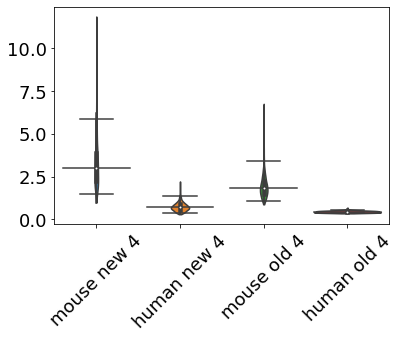

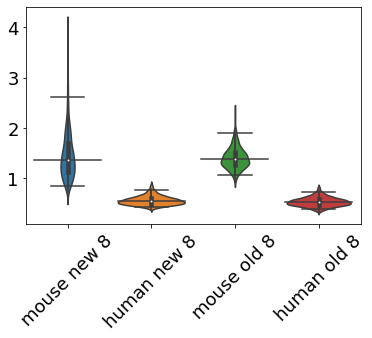

In [46]:
sns.boxplot(data=unlogrdf.iloc[:,0:4],showfliers=False, showbox=False, whis=[2.5,97.5])
g = sns.violinplot(data=unlogrdf.iloc[:,0:4], cut=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

sns.boxplot(data=unlogrdf.iloc[:,4:8],showfliers=False, showbox=False, whis=[2.5,97.5])
g = sns.violinplot(data=unlogrdf.iloc[:,4:8])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

<ipython-input-47-23a7474ba5e1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf[names[i]]= alldfs[i][['gamma_s']]


   mouse new 4   human new 4  mouse old 4  human old 4  mouse new 8  \
0     -0.149218    -0.649581    -0.041636    -0.526914     0.271100   
1     -0.261221    -0.577091    -0.117595    -0.432943     0.193921   
2     -0.192953    -0.586882    -0.265026    -0.483395     0.152943   
3     -0.330709    -0.650511    -0.258299    -0.408859     0.032403   
4     -0.412075    -0.505264    -0.131885    -0.430226     0.208262   

   human new 8  mouse old 8  human old 8  
0    -0.277636     0.105035    -0.311015  
1    -0.242430     0.111026    -0.267215  
2    -0.211198     0.159772    -0.369992  
3    -0.128732    -0.015956    -0.313250  
4    -0.241077     0.042708    -0.323944  
   mouse new 4   human new 4  mouse old 4  human old 4  mouse new 8  \
0      0.709221     0.224088     0.908581     0.297225     1.866808   
1      0.547998     0.264794     0.762790     0.369026     1.562863   
2      0.641279     0.258892     0.543218     0.328553     1.422141   
3      0.466972     0.223609   

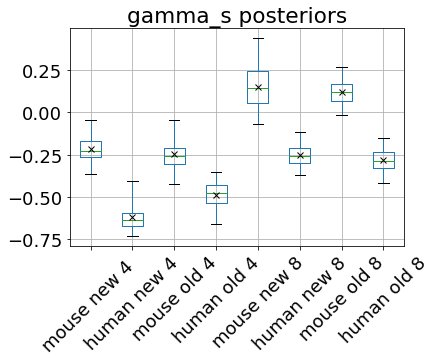

In [47]:
### gamma_s box plot

alldfs = [mouse4_riju_df, human4_riju_df, mouse4_rub_df, human4_rub_df, mouse8_riju_df, human8_riju_df, mouse8_rub_df, human8_rub_df]
names =['mouse new 4 ', 'human new 4', 'mouse old 4', 'human old 4', 'mouse new 8', 'human new 8', 'mouse old 8','human old 8']

gdf = mouse4_riju_df[['gamma_s']]
gdf.columns=[names[0]]

for i in range(1,len(alldfs)):
    gdf[names[i]]= alldfs[i][['gamma_s']]

print(gdf.head())

unloggdf = 10**gdf

print(unloggdf.head())

meanpointprops = dict(marker='x', markeredgecolor='black')
ax = gdf.boxplot(rot=45, showmeans=True, showfliers=False, meanprops=meanpointprops, whis=[2.5,97.5])
ax.set_title("gamma_s posteriors")
plt.show()

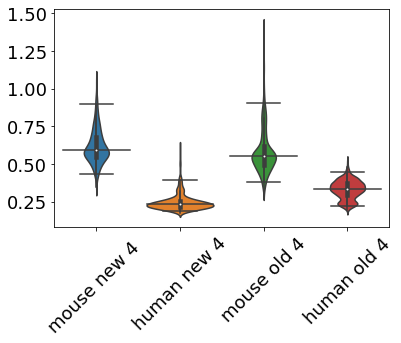

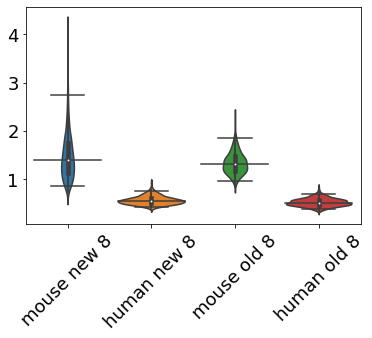

In [48]:
sns.boxplot(data=unloggdf.iloc[:,0:4],showfliers=False, showbox=False, whis=[2.5,97.5])
g = sns.violinplot(data=unloggdf.iloc[:,0:4])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

sns.boxplot(data=unloggdf.iloc[:,4:8],showfliers=False, showbox=False, whis=[2.5,97.5])
g = sns.violinplot(data=unloggdf.iloc[:,4:8])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

In [49]:
summary = gdf.describe()
print(summary)

       mouse new 4   human new 4  mouse old 4  human old 4  mouse new 8  \
count   1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      -0.215431    -0.617752    -0.247485    -0.488333     0.152554   
std        0.077049     0.081366     0.095473     0.084703     0.132311   
min       -0.457653    -0.754851    -0.481770    -0.708138    -0.136631   
25%       -0.263011    -0.669657    -0.306831    -0.537023     0.054306   
50%       -0.225987    -0.632580    -0.259054    -0.474085     0.145266   
75%       -0.166894    -0.592038    -0.208805    -0.427461     0.243771   
max        0.025068    -0.208971     0.143752    -0.283972     0.615014   

       human new 8  mouse old 8  human old 8  
count  1000.000000  1000.000000  1000.000000  
mean     -0.250621     0.122523    -0.282928  
std       0.066046     0.071684     0.068478  
min      -0.430304    -0.074683    -0.495579  
25%      -0.298389     0.070517    -0.329550  
50%      -0.254617     0.121188    -0.2856

## Bayesian credibility interval

From https://github.com/aloctavodia/BAP/blob/master/first_edition/code/Chp1/hpd.py


In [50]:
from __future__ import division
import numpy as np
import scipy.stats.kde as kde

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [51]:
# print(gdf.head())

parray = np.array(unloggdf.iloc[:,5])
# print(parray)

HPD = hpd_grid(parray, alpha=0.05, roundto=3)
print(HPD)

([(0.409, 0.754)], array([0.3712755 , 0.37156912, 0.37186274, ..., 0.9576393 , 0.95793292,
       0.95822654]), array([0.12520974, 0.12734159, 0.1295018 , ..., 0.04350977, 0.0433137 ,
       0.04311374]), [0.544])


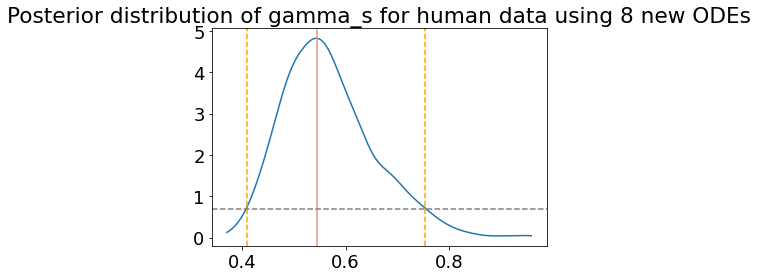

In [52]:
x1 =HPD[0][0][0]
x2 =HPD[0][0][1]

ax = plt.subplot()
ax.plot(HPD[1],HPD[2])
plt.axvline(x=x1, linestyle = '--', color='orange')
plt.axvline(x=x2, linestyle = '--', color='orange')
plt.axvline(x=HPD[3], linestyle = '-', color='darksalmon')
plt.axhline(y=0.7, linestyle='--', color='grey')
ax.set_title("Posterior distribution of gamma_s for human data using 8 new ODEs")
plt.savefig('CIgamma_s_human8new.png')
plt.show()

## Get credibility intervals and plot posteriors again using mode + with more points

In [53]:
alldfs = [mouse4_riju_df, human4_riju_df, mouse4_rub_df, human4_rub_df, mouse8_riju_df, human8_riju_df, mouse8_rub_df, human8_rub_df]
names =['mouse new 4 ', 'human new 4', 'mouse old 4', 'human old 4', 'mouse new 8', 'human new 8', 'mouse old 8','human old 8']

# print(mouse4_riju_df)

In [54]:
rijparamnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'psiI', 'psiP', 'psiO', 'psiN']
rubparamnames = ['r_s', 'gamma_s', 'K_NI', 'K_OI', 'K_NP', 'K_OP', 'K_IO', 'K_NO', 'K_GO', 'K_IN', 'K_PN', 'K_ON', 'K_GN', 'K_LN', 'K_LP', 'K_LI','K_LO']


def get_CI(df, group, pars,r):
    CIlower=[]
    CIupper=[]
    modes=[]
    for i in range(r):
        parray = np.array(df.iloc[:,i])
        HPD = hpd_grid(parray, alpha=0.05, roundto=3)
        modes.append(HPD[3][0])
        CIlower.append(HPD[0][0][0])
        CIupper.append(HPD[0][0][1])
        
#     print(group)
#     print(modes, '\n') 
    
    modes = 10**np.array(modes)
    CIlower = 10**np.array(CIlower)
    CIupper = 10**np.array(CIupper)
    
#     print(modes, '\n') 
#     print(CIlower)
#     print(CIupper)
    postdf= pd.DataFrame(list(zip(pars, CIlower, modes, CIupper)), columns = ['Param', 'CI lower', 'Mode', 'CI upper'])
    
#     print(postdf.head(20))
    return modes, CIlower, CIupper
    
#     postdf.to_csv("CI "+ group + ".csv")
    
for i in [2,3,6,7]:
    get_CI(alldfs[i], names[i], rubparamnames,17)

[2.92395951 0.60376041 1.40585755 0.08128707 1.16824013 0.23647705
 0.5662515  0.21309677]


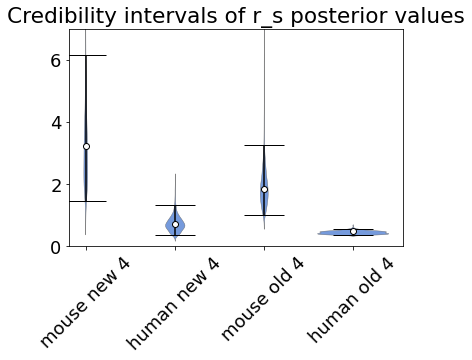

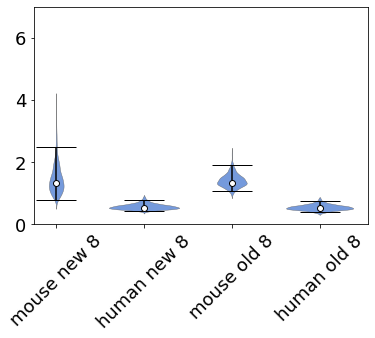

[0.3185983  0.13359216 0.37217261 0.0914481  1.1999009  0.21655379
 0.49095517 0.217904  ]


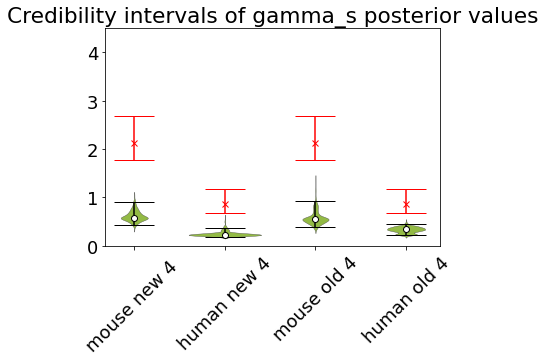

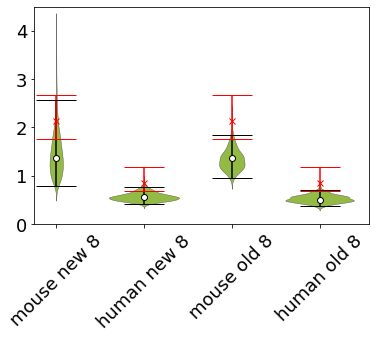

In [55]:
### print(rdf.head())
names =['','mouse new 4 ', 'human new 4', 'mouse old 4', 'human old 4', 'mouse new 8', 'human new 8', 'mouse old 8','human old 8']


x=[0,1,2,3,4,5,6,7]

hpd_r = get_CI(rdf, 'r_s', names,8)

diffupper = hpd_r[2]-hpd_r[0]
print(diffupper)
difflower = hpd_r[0]-hpd_r[1]
yerr1= np.array([difflower[0:4], diffupper[0:4]])
yerr2= np.array([difflower[4:8], diffupper[4:8]])


######### r_s
ax=plt.subplot()
g = sns.violinplot(data=unlogrdf.iloc[:,0:4], color='cornflowerblue', inner=None, linewidth = 0.4)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.errorbar(x[0:4],hpd_r[0][0:4],yerr=yerr1, linestyle='', marker='o', capsize=20, label=names, mec="black", c="white", ecolor="black")
# ax.set_xticklabels(names, rotation=45)
plt.ylim(0, 7)
ax.set_title("Credibility intervals of r_s posterior values")
plt.show()

ax=plt.subplot()
g = sns.violinplot(data=unlogrdf.iloc[:,4:8], color='cornflowerblue', inner=None, linewidth = 0.4)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.errorbar(x[0:4],hpd_r[0][4:8],yerr=yerr2, linestyle='', marker='o', capsize=20, label=names, mec="black", c="white", ecolor="black")
# ax.set_xticklabels(names, rotation=45)
plt.ylim(0, 7)
# ax.set_title("Credibility intervals of r_s posterior values")
plt.show()


######### gamma_s
hpd_g = get_CI(gdf, 'gamma_s', names,8)
deg = [2.13,0.86,2.13,0.86]
uplow =[[0.36,0.18,0.36,0.18],[0.55,0.32,0.55,0.32]]


diffupper = hpd_g[2]-hpd_g[0]
print(diffupper)
difflower = hpd_g[0]-hpd_g[1]
yerr1= np.array([difflower[0:4], diffupper[0:4]])
yerr2= np.array([difflower[4:8], diffupper[4:8]])

ax=plt.subplot()
g = sns.violinplot(data=unloggdf.iloc[:,0:4], color='yellowgreen', inner=None, linewidth = 0.4)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.errorbar(x[0:4],hpd_g[0][0:4],yerr=yerr1, linestyle='', marker='o', capsize=20, label=names, mec="black", c="white", ecolor="black")
plt.errorbar(x[0:4],deg,yerr=uplow, linestyle=' ', marker='x', capsize=20, mec="red", c="red", ecolor="red")
plt.ylim(0, 4.5)
ax.set_title("Credibility intervals of gamma_s posterior values")
plt.show()

ax=plt.subplot()
g = sns.violinplot(data=unloggdf.iloc[:,4:8], color='yellowgreen', inner=None, linewidth = 0.4)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.errorbar(x[0:4],hpd_g[0][4:8],yerr=yerr2, linestyle='', marker='o', capsize=20, label=names, mec="black", c="white", ecolor="black")
plt.errorbar(x[0:4],deg,yerr=uplow, linestyle=' ', marker='x', capsize=20, mec="red", c="red", ecolor="red")

# ax.set_xticklabels(names, rotation=45)
plt.ylim(0, 4.5)
# ax.set_title("Credibility intervals of gamma_s posterior values")
plt.show()



## Smoothened posteriors

In [75]:
mouse4newp = [0.507, -0.239, -0.724, 2.231, 2.274, 1.504, -0.838, 0.759, 1.525, -0.71, 1.789, -0.545, -0.588, -1.644, -2.199, -2.344, -0.701]
human4newp = [-0.146, -0.644, 1.97, 1.929, -2.096, -1.945, -1.779, 0.592, 1.326, 0.619, -2.239, -1.022, -0.306, -1.638, -2.343, -1.718, -2.38]

mouse8newp = [0.117, 0.135, 0.335, -1.109, 0.555, -0.813, -1.152, 0.154, 1.281, -0.387, 0.262, -1.343, 1.154, -2.047, -1.673, -2.484, -2.431] 
human8newp = [-0.275, -0.259, 0.639, 0.186, 0.78, -1.737, -0.339, 0.118, 1.319, 0.492, -1.218, -0.88, 1.079, -1.121, -1.215, -2.161, -1.139]

mouse4oldp = [0.266, -0.261, 1.716, 0.043, 1.675, -0.171, -1.129, 1.619, 1.36, -0.725, -0.933, -1.923, -1.808, -0.292, -1.457, 0.005, 1.043]
human4oldp =[-0.326, -0.452, -0.967, 1.558, 1.145, -1.821, -1.362, 1.635, -0.253, 0.497, -0.037, -2.232, -0.292, 0.417, 0.491, 1.001, 2.589]

mouse8oldp =[0.124, 0.133, 0.723, -2.108, 0.994, -0.121, -1.228, 1.517, 1.861, 0.729, 1.135, -1.131, 0.335, 2.673, 1.891, 1.167, 1.94] 
human8oldp = [-0.28, -0.304, 0.875, 0.094, 0.679, -0.817, -2.059, 1.091, 1.809, 1.025, 0.477, -0.659, 1.574, 0.72, 0.82, 0.892, 1.477] 

npts =100


In [76]:
### load data functions ###
def load_data(csvname, gene_names, mouse=True):
    df = pd.read_csv(csvname) # load csv
    df = pd.read_csv(csvname) # load csv
    df = df.loc[df['Gene'].isin(gene_names)] # select genes of interest only
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

    # initialise empty variables
    start=0
    end=0
    timepts=[]

    if mouse:
        df = df[df.columns.drop(list(df.filter(regex='h_')))]
        df = df[df.columns.drop(list(df.filter(regex='m_0_')))]
        end=33

    else:
        df = df[df.columns.drop(list(df.filter(regex='m_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_0_')))]
        df = df[df.columns.drop(list(df.filter(regex='h_1_')))]
        end=39

    means=[]

    for gene_id in gene_names:
        genearr = np.array(df[df.Gene == gene_id].drop(labels='Gene', axis =1))
        genes_scaled = min_max_scaler.fit_transform(genearr.reshape(len(genearr[0]),1)) # normalise data from 0 to 1
        genes_scaled = genes_scaled.reshape(1,len(genes_scaled))[0]
        rep1 = genes_scaled[[i for i in range(0,end,3)]]
        rep2 = genes_scaled[[i for i in range(1,end,3)]]
        rep3 = genes_scaled[[i for i in range(2,end,3)]]

        repmean=(rep1+rep2+rep3)/3
        means.append(repmean)

    run_array = np.array(means).T
    return run_array

mouseobs = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = True)    
humanobs = load_data(csvname='vst_transformed.csv', gene_names=gene_names, mouse = False) 

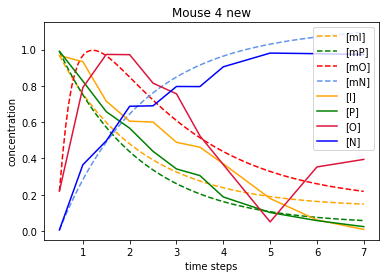

In [77]:
# mouse 4 new

tpts = np.linspace(0.5,7,npts)
timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]

X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[2])**2)*(1+((10**K_NI)*X[3])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[2])**2)*(1+((10**K_NP)*X[3])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[0])**2)*(1+((10**K_NO)*X[3])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[0])**2)*(1+((10**K_PN)*X[1])**2)*(1+((10**K_ON)*X[2])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dI_dt = (10**r_s)*phi_I - (10**gamma_s)*X[0]
    dP_dt = (10**r_s)*phi_P - (10**gamma_s)*X[1]
    dO_dt = (10**r_s)*phi_O- (10**gamma_s)*X[2]
    dN_dt = (10**r_s)*phi_N- (10**gamma_s)*X[3]

    return np.array([dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span =[0.5,20], t_eval=tpts, args =tuple(parameter_list), dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 

simulateposterior = simulate_data(mouse4newp)

_, ax = plt.subplots()
ax.plot(tpts, simulateposterior[:, 0], "--", color="orange", label="[mI]")
ax.plot(tpts, simulateposterior[:, 1], "--", color="green", label="[mP]")
ax.plot(tpts, simulateposterior[:, 2], "--", color="red",label="[mO]")
ax.plot(tpts, simulateposterior[:, 3], "--", color="cornflowerblue",label="[mN]")

ax.plot(timepts, mouseobs[:, 0], "-", label="[I]", color = "orange")
ax.plot(timepts, mouseobs[:, 1], "-", label="[P]", color = "green")
ax.plot(timepts, mouseobs[:, 2], "-", label="[O]", color = "crimson")
ax.plot(timepts, mouseobs[:, 3], "-", label="[N]", color = "blue")

ax.set_xlabel("time steps")
ax.set_ylabel("concentration")
ax.set_title("Mouse 4 new")
ax.legend(loc="upper right");
# plt.savefig("simulated_trajectories_"+spec+"/"+time.strftime("%Y_%m_%d_%H%M") + "_trajectories_at_thresh" + str(thresh) + ".png")


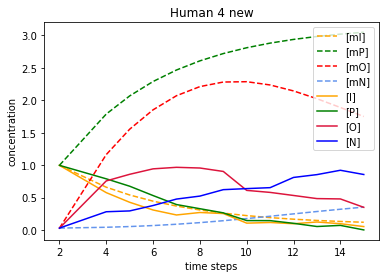

In [180]:
# human 4 new

def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span =[2,20], t_eval=timepts, args =tuple(parameter_list), dense_output=True) 
    run_array = np.array(run.y).T
    return run_array

X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]
t_range = [2,15]
timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
tpts = np.linspace(2,15,npts)

simulateposterior = simulate_data(human4newp)

_, ax = plt.subplots()
ax.plot(timepts, simulateposterior[:, 0], "--", color="orange", label="[mI]")
ax.plot(timepts, simulateposterior[:, 1], "--", color="green", label="[mP]")
ax.plot(timepts, simulateposterior[:, 2], "--", color="red",label="[mO]")
ax.plot(timepts, simulateposterior[:, 3], "--", color="cornflowerblue",label="[mN]")

ax.plot(timepts, humanobs[:, 0], "-", label="[I]", color = "orange")
ax.plot(timepts, humanobs[:, 1], "-", label="[P]", color = "green")
ax.plot(timepts, humanobs[:, 2], "-", label="[O]", color = "crimson")
ax.plot(timepts, humanobs[:, 3], "-", label="[N]", color = "blue")

ax.set_xlabel("time steps")
ax.set_ylabel("concentration")
ax.set_title("Human 4 new")
ax.legend(loc="upper right");


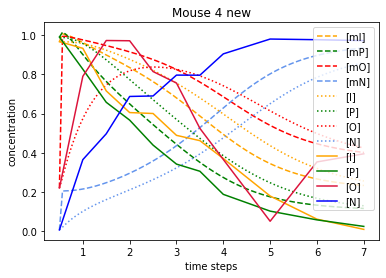

In [174]:
# mouse 8 new

tpts = np.linspace(0.5,7,npts)
timepts=[0.5,1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7]

X0 = [0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383, 0.9673932616381912, 0.9905698391107712, 0.22032352020457502, 0.006276499439069383]

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[6])**2)*(1+((10**K_NI)*X[7])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[6])**2)*(1+((10**K_NP)*X[7])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[4])**2)*(1+((10**K_NO)*X[7])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[4])**2)*(1+((10**K_PN)*X[5])**2)*(1+((10**K_ON)*X[6])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]

    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]

    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span =[0.5,20], t_eval=tpts, args =tuple(parameter_list), dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 

simulateposterior = simulate_data(mouse8newp)

_, ax = plt.subplots()
ax.plot(tpts, simulateposterior[:, 0], "--", color="orange", label="[mI]")
ax.plot(tpts, simulateposterior[:, 1], "--", color="green", label="[mP]")
ax.plot(tpts, simulateposterior[:, 2], "--", color="red",label="[mO]")
ax.plot(tpts, simulateposterior[:, 3], "--", color="cornflowerblue",label="[mN]")
ax.plot(tpts, simulateposterior[:, 4], ":", color="orange", label="[I]")
ax.plot(tpts, simulateposterior[:, 5], ":", color="green", label="[P]")
ax.plot(tpts, simulateposterior[:, 6], ":", color="red",label="[O]")
ax.plot(tpts, simulateposterior[:, 7], ":", color="cornflowerblue",label="[N]")


ax.plot(timepts, mouseobs[:, 0], "-", label="[I]", color = "orange")
ax.plot(timepts, mouseobs[:, 1], "-", label="[P]", color = "green")
ax.plot(timepts, mouseobs[:, 2], "-", label="[O]", color = "crimson")
ax.plot(timepts, mouseobs[:, 3], "-", label="[N]", color = "blue")

ax.set_xlabel("time steps")
ax.set_ylabel("concentration")
ax.set_title("Mouse 4 new")
ax.legend(loc="upper right");
# plt.savefig("simulated_trajectories_"

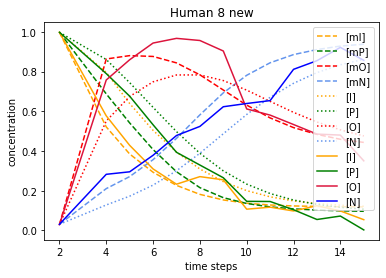

In [177]:
# human 8 new 

timepts=[2,4,5,6,7,8,9,10,11,12,13,14,15]
tpts = np.linspace(2,15,npts)
X0 = [0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577, 0.9978271229639294, 0.9976673744053118, 0.029296758259304223, 0.03117422425335577]

def ODEs(t, X, r_s, gamma_s, K_NI, K_OI, K_NP, K_OP, K_IO, K_NO, K_GO, K_IN, K_PN, K_ON, K_GN, psiI, psiP, psiO, psiN):

    phi_I = (1/((1+((10**K_OI)*X[6])**2)*(1+((10**K_NI)*X[7])**2))+ (10**psiI))
    phi_P = (1/((1+((10**K_OP)*X[6])**2)*(1+((10**K_NP)*X[7])**2))+ (10**psiP))
    phi_O = ((((10**K_GO*G))**2)/((1+((10**K_IO)*X[4])**2)*(1+((10**K_NO)*X[7])**2)*(1+((10**K_GO)*G)**2)) + (10**psiO))
    phi_N = ((((10**K_GN*G))**2)/((1+((10**K_IN)*X[4])**2)*(1+((10**K_PN)*X[5])**2)*(1+((10**K_ON)*X[6])**2)*(1+((10**K_GN)*G)**2)) + (10**psiN))

    dmI_dt = alpha_s*phi_I - alpha_s*X[0]
    dmP_dt = alpha_s*phi_P - alpha_s*X[1]
    dmO_dt = alpha_s*phi_O - alpha_s*X[2]
    dmN_dt = alpha_s*phi_N - alpha_s*X[3]

    dI_dt = (10**r_s)*X[0] - (10**gamma_s)*X[4]
    dP_dt = (10**r_s)*X[1] - (10**gamma_s)*X[5]
    dO_dt = (10**r_s)*X[2] - (10**gamma_s)*X[6]
    dN_dt = (10**r_s)*X[3] - (10**gamma_s)*X[7]

    return np.array([dmI_dt, dmP_dt, dmO_dt, dmN_dt, dI_dt, dP_dt, dO_dt, dN_dt])


  # simulator function - only going to vary alpha and beta for now 
def simulate_data(parameter_list):
    run= solve_ivp(ODEs, y0=X0, t_span =[2,20], t_eval=timepts, args =tuple(parameter_list), dense_output=True) 
    run_array = np.array(run.y).T
    return run_array 

simulateposterior = simulate_data(human8newp)

_, ax = plt.subplots()
ax.plot(timepts, simulateposterior[:, 0], "--", color="orange", label="[mI]")
ax.plot(timepts, simulateposterior[:, 1], "--", color="green", label="[mP]")
ax.plot(timepts, simulateposterior[:, 2], "--", color="red",label="[mO]")
ax.plot(timepts, simulateposterior[:, 3], "--", color="cornflowerblue",label="[mN]")
ax.plot(timepts, simulateposterior[:, 4], ":", color="orange", label="[I]")
ax.plot(timepts, simulateposterior[:, 5], ":", color="green", label="[P]")
ax.plot(timepts, simulateposterior[:, 6], ":", color="red",label="[O]")
ax.plot(timepts, simulateposterior[:, 7], ":", color="cornflowerblue",label="[N]")


ax.plot(timepts, humanobs[:, 0], "-", label="[I]", color = "orange")
ax.plot(timepts, humanobs[:, 1], "-", label="[P]", color = "green")
ax.plot(timepts, humanobs[:, 2], "-", label="[O]", color = "crimson")
ax.plot(timepts, humanobs[:, 3], "-", label="[N]", color = "blue")

ax.set_xlabel("time steps")
ax.set_ylabel("concentration")
ax.set_title("Human 8 new")
ax.legend(loc="upper right");
# plt.savefig("simulated_trajectories_"
